In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import kagglehub
import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [ ]:

path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

print("Path to dataset files:", path)

100%|██████████| 385M/385M [00:20<00:00, 20.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2


In [ ]:
dataset = PlayingCardDataset(
    data_dir='/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train'
)

len(dataset)

7624

In [ ]:
dataset[400].class_to_idx.items()


AttributeError: 'tuple' object has no attribute 'class_to_idx'

In [ ]:
data_dir='/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [ ]:
# Use transforms.compose method to reformat images for modeling,
# and save to variable all_transforms for later use
print(device)


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = PlayingCardDataset(data_dir, transform)

cuda


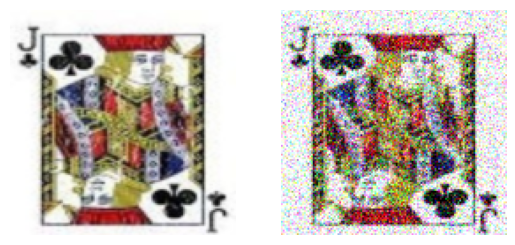

In [ ]:
tensor_data = dataset[2484][0]
noise = torch.randn_like(tensor_data) * 0.2
noise_image = (tensor_data + noise).numpy()
image = (tensor_data ).numpy()
tensor_data = np.transpose(image, (1, 2, 0))
tensor_noise = np.transpose(noise_image, (1, 2, 0))  # CxHxW -> HxWxC
tensor_noise = np.transpose(noise_image, (1, 2, 0))

plt.subplot(1, 2, 1)
plt.imshow(tensor_data)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(tensor_noise)
plt.axis("off")
plt.show()

In [ ]:


print(images.shape, labels.shape)
print(labels)

torch.Size([64, 3, 128, 128]) torch.Size([64])
tensor([12, 34, 28, 22, 51, 28, 34, 41, 28, 30, 52, 17, 24,  7, 29,  8,  5, 24,
        41,  7, 51, 27, 40, 43, 36,  7, 42, 17, 11,  8, 10, 25, 40, 45, 20, 37,
        35, 15, 21, 49, 40, 16, 36,  2, 16, 13, 17, 22, 15, 27, 10,  3, 36, 11,
         1, 51, 18, 34,  2, 37, 43, 18, 44, 33])


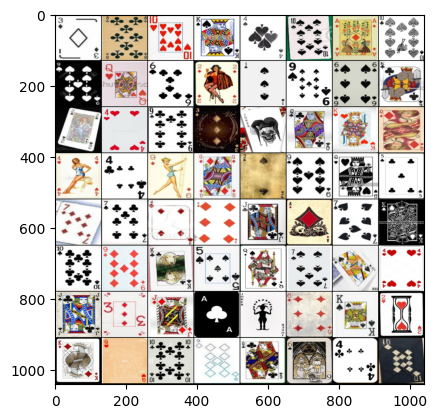

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = PlayingCardDataset(data_dir, transform)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
for images, labels in dataloader:
    break

def imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

img_grid = torchvision.utils.make_grid(images)

# Display the grid of images
imshow(img_grid)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train/'
valid_folder = '/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/valid/'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes=53):
        super(ConvNeuralNet, self).__init__()

        # First Convolutional Block: Conv -> ReLU -> MaxPooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)  # Output: 6 x 64 x 64
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 6 x 32 x 32

        # Second Convolutional Block: Conv -> ReLU -> MaxPooling
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=32, kernel_size=5)  # Output: 32 x 28 x 28
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 32 x 14 x 14

        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=32 * 29 * 29, out_features=120)  # Flattened size: 32 * 19 * 19
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=120, out_features=32)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=32, out_features=num_classes)

    def forward(self, x):
        # Forward pass through Convolutional Layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten before Fully Connected Layers
        x = x.view(x.size(0), -1)  # Flatten the output of conv2

        # Forward pass through Fully Connected Layers  32x26912 and 6272x120
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)

        return x

In [ ]:
sum(p.numel() for p in model.parameters())

3240469

In [ ]:
# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

model = ConvNeuralNet(53)
# Set optimizer with optimizer
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9)


In [ ]:
# Training loop
print("Starting training...")
total_step = len(train_loader)
num_epochs=10
model = ConvNeuralNet(num_classes=53).to(device)
train_losses, val_losses = [], []

for epoch in range(5):
    epoch_loss = 0.0  # Track total loss for the epoch
    running_loss = 0.0
    for i, (image, label) in enumerate(tqdm(train_loader, desc='Training loop')):
            # Move tensors to GPU/CPU
            image = image.to(device)
            label = label.to(device)

                    # Forward pass
            outputs = model(image)
            loss = criterion(outputs, label)

                  # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            running_loss += loss.item() * labels.size(0)
            # Print batch progress
            if (i + 1) % 80 == 0:  # Adjust frequency as needed
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Calculate average loss for the epoch

    epoch_loss /= len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Completed. Average Loss: {epoch_loss:.4f}")

       # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Starting training...


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Epoch [1/10], Step [80/239], Loss: 3.9745
Epoch [1/10], Step [160/239], Loss: 3.9703
Epoch [1/10] Completed. Average Loss: 7.9183


Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10 - Train loss: 1.1216876348255813, Validation loss: 3.9757676205545103


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Epoch [2/10], Step [80/239], Loss: 3.9888
Epoch [2/10], Step [160/239], Loss: 3.9691
Epoch [2/10] Completed. Average Loss: 7.9181


Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/10 - Train loss: 1.1216608819718876, Validation loss: 3.9757676205545103


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Epoch [3/10], Step [80/239], Loss: 3.9855
Epoch [3/10], Step [160/239], Loss: 3.9701
Epoch [3/10] Completed. Average Loss: 7.9181


Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/10 - Train loss: 1.1216677453873165, Validation loss: 3.9757676205545103


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Epoch [4/10], Step [80/239], Loss: 3.9552
Epoch [4/10], Step [160/239], Loss: 3.9864
Epoch [4/10] Completed. Average Loss: 7.9181


Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/10 - Train loss: 1.121661734480923, Validation loss: 3.9757676205545103


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Epoch [5/10], Step [80/239], Loss: 3.9633
Epoch [5/10], Step [160/239], Loss: 3.9758
Epoch [5/10] Completed. Average Loss: 7.9181


Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/10 - Train loss: 1.121655159832173, Validation loss: 3.9757676205545103


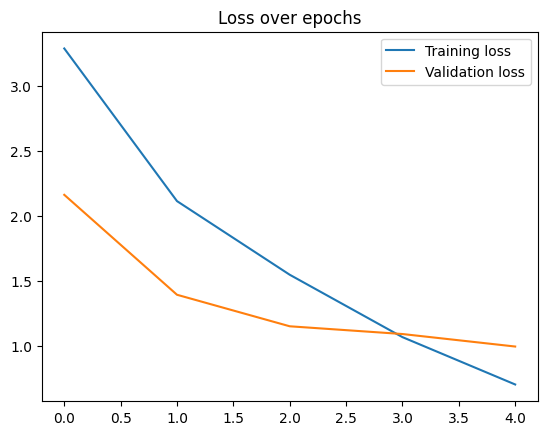

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [ ]:
import torch
import torch.nn as nn

class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes=53):
        super(ConvNeuralNet, self).__init__()

        # First Convolutional Block: Conv -> Sigmoid -> MaxPooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)  # Output: 6 x 64 x 64
        self.sigmoid1 = nn.Sigmoid()  # Use Sigmoid activation instead of ReLU
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 6 x 32 x 32

        # Second Convolutional Block: Conv -> Sigmoid -> MaxPooling
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=32, kernel_size=5)  # Output: 32 x 28 x 28
        self.sigmoid2 = nn.Sigmoid()  # Use Sigmoid activation instead of ReLU
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 32 x 14 x 14

        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=32 * 29 * 29, out_features=120)  # Flattened size: 32 * 29 * 29
        self.sigmoid3 = nn.Sigmoid()  # Use Sigmoid activation instead of ReLU
        self.fc2 = nn.Linear(in_features=120, out_features=32)
        self.sigmoid4 = nn.Sigmoid()  # Use Sigmoid activation instead of ReLU
        self.fc3 = nn.Linear(in_features=32, out_features=num_classes)

    def forward(self, x):
        # Forward pass through Convolutional Layers
        x = self.conv1(x)
        x = self.sigmoid1(x)  # Apply Sigmoid activation using Sigmoid() function
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.sigmoid2(x)  # Apply Sigmoid activation using Sigmoid() function
        x = self.pool2(x)

        # Flatten before Fully Connected Layers
        x = x.view(x.size(0), -1)  # Flatten the output of conv2

        # Forward pass through Fully Connected Layers
        x = self.fc1(x)
        x = self.sigmoid3(x)  # Apply Sigmoid activation using Sigmoid() function
        x = self.fc2(x)
        x = self.sigmoid4(x)  # Apply Sigmoid activation using Sigmoid() function
        x = self.fc3(x)

        return x


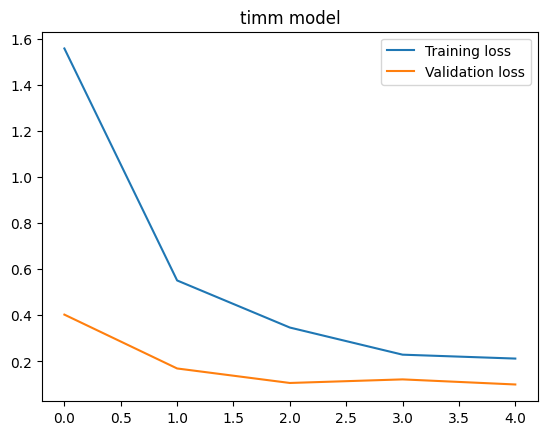

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("timm model")
plt.show()

In [ ]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [ ]:
model = SimpleCardClassifer(53)
sum(p.numel() for p in model2.parameters())

NameError: name 'model2' is not defined

In [ ]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5574870561127399, Validation loss: 0.4029812659857408


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5511619186288788, Validation loss: 0.16936742089829354


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.3468720593332369, Validation loss: 0.10644199544528746


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.22921151092426476, Validation loss: 0.12198607527984763


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.21231162139182325, Validation loss: 0.09991163802596759


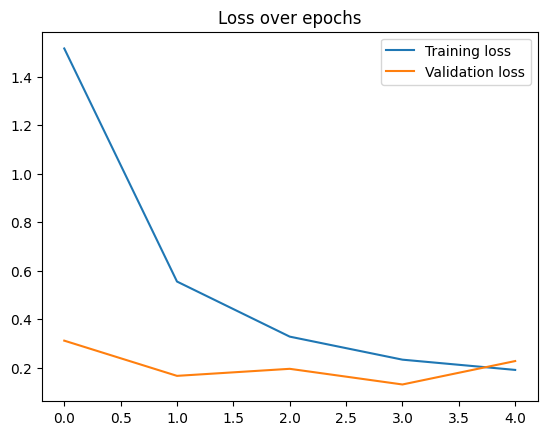

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [ ]:
# Simple training loop
num_epochs = 8
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):

        noise = torch.randn(3, 128, 128) * 0.1
        image = images + noise
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/8 - Train loss: 1.5884573706049483, Validation loss: 0.42317897058882803


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/8 - Train loss: 0.5735548053245605, Validation loss: 0.3419630154123846


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/8 - Train loss: 0.32895900690605606, Validation loss: 0.14454118755628478


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/8 - Train loss: 0.23854359740475417, Validation loss: 0.169777937936333


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/8 - Train loss: 0.18952296533527055, Validation loss: 0.187168876180109


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/8 - Train loss: 0.14701023551851417, Validation loss: 0.10591912393300039


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/8 - Train loss: 0.16398828070520854, Validation loss: 0.1509494517209395


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/8 - Train loss: 0.10331744122575941, Validation loss: 0.03201422992179979


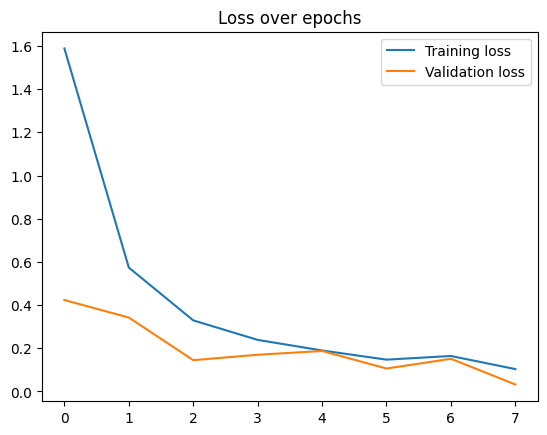

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [ ]:
# Simple training loop
num_epochs = 10
train_losses, val_losses = [], []
noise_prc = 0.01
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):

        noise = torch.randn(3, 128, 128) * noise_prc
        image = images + noise
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10 - Train loss: 1.5555599842842078, Validation loss: 0.48983498879198756


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/10 - Train loss: 0.5513845496387821, Validation loss: 0.271912416197219


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/10 - Train loss: 0.3240377933318567, Validation loss: 0.20415598440845056


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/10 - Train loss: 0.2503901931602832, Validation loss: 0.1800775127590827


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/10 - Train loss: 0.19243982400264345, Validation loss: 0.10287076544086889


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/10 - Train loss: 0.14839412440259522, Validation loss: 0.15420931285282352


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/10 - Train loss: 0.1484949777385558, Validation loss: 0.14956822743955647


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/10 - Train loss: 0.12361042860578765, Validation loss: 0.2137653556072487


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/10 - Train loss: 0.09370788878977204, Validation loss: 0.1933265078742549


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/10 - Train loss: 0.0985340905099216, Validation loss: 0.06946166506353414


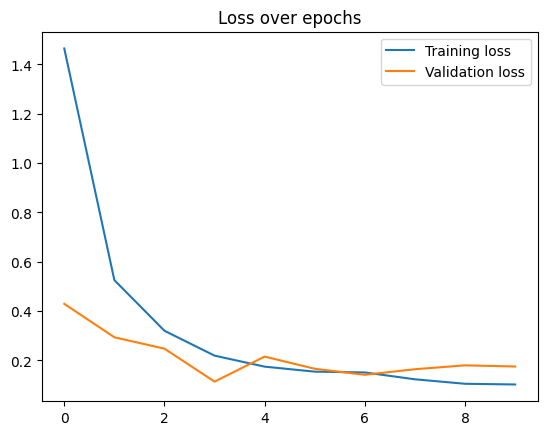

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()